In [1]:
import pandas as pd
import numpy as np
import utils
import os

### Merge SDSS and image mapping columns into spec_sample and phot_sample

In [ ]:
spec_sample = pd.read_csv("data/zoo2MainSpecz.csv")
phot_sample = pd.read_csv("data/zoo2MainPhotoz.csv")
SDSS = pd.read_csv("data/gz2sample.csv")
image_mapping = pd.read_csv("data/3565489/gz2_filename_mapping.csv")

In [ ]:
# Merge spec_sample with SDSS on the dr7objid and OBJID columns
spec_sample = spec_sample.merge(SDSS[['OBJID', 'REDSHIFT', 'REDSHIFTERR',
                                      'PETROR50_R', 'PETROR90_R', 'PETROMAG_U',
                                      'PETROMAG_G', 'PETROMAG_R', 'PETROMAG_I',
                                      'PETROMAG_Z', 'PETROMAGERR_U', 'PETROMAGERR_G',
                                      'PETROMAGERR_R', 'PETROMAGERR_I', 'PETROMAGERR_Z']], 
                                left_on='dr7objid', 
                                right_on='OBJID', 
                                how='left')

phot_sample = phot_sample.merge(SDSS[['OBJID', 'PETROR50_R', 'PETROR90_R',
                                      'PETROMAG_U', 'PETROMAG_G', 'PETROMAG_R', 'PETROMAG_I',
                                      'PETROMAG_Z', 'PETROMAGERR_U', 'PETROMAGERR_G',
                                      'PETROMAGERR_R', 'PETROMAGERR_I', 'PETROMAGERR_Z']], 
                                left_on='dr7objid', 
                                right_on='OBJID', 
                                how='left')

# Drop the redundant OBJID column after merging
spec_sample.drop(columns=['OBJID'], inplace=True)
phot_sample.drop(columns=['OBJID'], inplace=True)

In [ ]:
# Merge spec_sample with SDSS on the dr7objid and OBJID columns
spec_sample = spec_sample.merge(image_mapping[['objid', 'asset_id']], 
                                left_on='dr7objid', 
                                right_on='objid', 
                                how='left')

phot_sample = phot_sample.merge(image_mapping[['objid', 'asset_id']], 
                                left_on='dr7objid', 
                                right_on='objid', 
                                how='left')

# Drop the redundant objid column after merging
spec_sample.drop(columns=['objid'], inplace=True)
phot_sample.drop(columns=['objid'], inplace=True)

In [ ]:
spec_sample.to_csv("data/spec_sample.csv", index=False)
phot_sample.to_csv("data/phot_sample.csv", index=False)

### Remove entries in spec_sample without images present

In [ ]:
df = pd.read_csv("data/spec_sample.csv")

In [ ]:
missing_asset_ids = []

for index, row in df.iterrows():
    file_path = f"data/3565489/images/{row['asset_id']}.jpg"
    if os.path.exists(file_path):
        pass
        # print(f"File exists: {file_path}")
    else:
        # print(f"{file_path}", row['asset_id'])
        missing_asset_ids.append(row['asset_id'])
        
print(len(missing_asset_ids) / len(df))

In [ ]:
df = df[~df['asset_id'].isin(missing_asset_ids)]
df.to_csv("data/spec_sample.csv", index=False)

### Merge 

### Test utils

In [ ]:
utils.show_image_by_assetid(523)

### Simplify morphology classification column and add ancillary classification columns

In [ ]:
df = pd.read_csv("data/spec_sample.csv", index_col=None)

In [ ]:
special_features = {
    'ring': r'\(r\)',
    'lens/arc': r'\(l\)',
    'disturbed': r'\(d\)',
    'irregular': r'\(i\)',
    'other': r'\(o\)',
    'merger': r'\(m\)',
    'dust lane': r'\(u\)',
}

df['morphology'] = df['gz2class']

for feature, pattern in special_features.items():
    df[feature] = 0
    df.loc[df['gz2class'].str.contains(pattern, na=False), feature] = 1
    df['morphology'] = df['morphology'].str.replace(pattern, '', regex=True)



In [ ]:
df['arm_count'] = df['morphology'].apply(lambda x: x[-2] if (x.startswith('S')) and (len(x) >3) else None)
df['arm_winding'] = df['morphology'].apply(lambda x: x[-1] if (x.startswith('S')) and (len(x) >3) else None)

df['morphology'] = df['morphology'].apply(lambda x: x[:-2] if (x.startswith('S') and len(x) > 3) else x)

In [ ]:
df.to_csv("data/spec_sample.csv", index=False)

In [ ]:
for asset_id in df.loc[df['arm_winding'] == 't', 'asset_id'].to_numpy()[0:5]:
    print(asset_id)
    utils.show_image_by_assetid(asset_id)
    

In [2]:
emb = pd.read_csv("embedding.csv", index_col=None)
spec_sample = pd.read_csv("data/spec_sample.csv", index_col=None)

In [3]:
# Merge spec_sample with SDSS on the dr7objid and OBJID columns
emb = emb.merge(spec_sample[['dr7objid', 'asset_id', 'REDSHIFT', 'morphology']], 
                left_on='dr7objid', 
                right_on='dr7objid', 
                how='left')


In [20]:
emb['is_spiral'] = emb['morphology'].apply(lambda x: 1 if str(x).startswith("S") else 0)


In [ ]:
embedding_vectors = [row['embedding_0':'embedding_767'].values for _, row in emb.iterrows()]
np.shape(embedding_vectors)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the data
X = np.array(embedding_vectors)
y = emb['is_spiral']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6153846153846154
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.86      0.60      0.71        10

    accuracy                           0.62        13
   macro avg       0.60      0.63      0.58        13
weighted avg       0.74      0.62      0.65        13



In [23]:
y.value_counts()

is_spiral
1    39
0    25
Name: count, dtype: int64

In [9]:
import umap.umap_ as umap

# Initialize UMAP with default parameters
umap_model = umap.UMAP()

# Fit and transform the embedding vectors
embedding_2d = umap_model.fit_transform(embedding_vectors)

# Convert the result to a DataFrame for easier handling
embedding_2d_df = pd.DataFrame(embedding_2d, columns=['UMAP_1', 'UMAP_2'])

# Display the first few rows of the transformed data
print(embedding_2d_df.head())

     UMAP_1    UMAP_2
0 -5.146995  7.430685
1 -2.115510  7.082428
2 -4.116408  4.768233
3 -5.021402  7.854345
4 -2.173412  6.629585


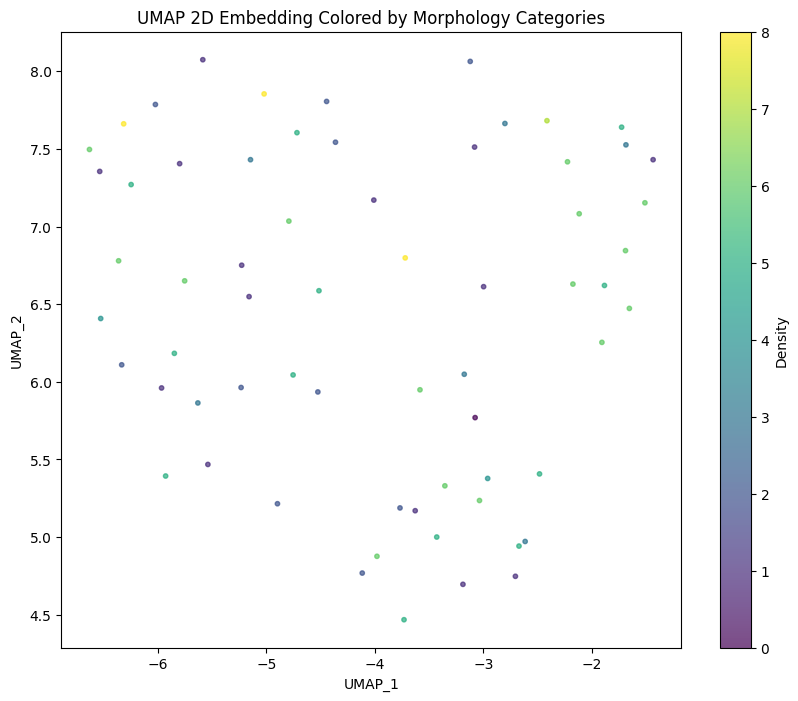

In [13]:
import matplotlib.pyplot as plt

# Create a scatter plot of the UMAP 2D embedding
plt.figure(figsize=(10, 8))
categories = emb['morphology'].astype('category').cat.codes
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=categories, s=10, alpha=0.7, cmap='viridis')
plt.title('UMAP 2D Embedding Colored by Morphology Categories')
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.colorbar(label='Density')
plt.show()